# COVID-19 Confirmed Cases vs. Deaths
> Analysis comparing the number of confirmed cases to the number of deaths across countries.

- comments: true
- author: Caglar Cakan
- categories: [growth, death, compare]
- permalink: /covid-cases-to-deaths/
- image: images/covid-cases-to-deaths.png
- license: Creative Commons

In [1]:
#hide_input
import datetime
print("Last build ", datetime.datetime.now().strftime("%d.%m.%y %H:%M:%S"))

Last build  21.03.20 17:15:59


In [2]:
#hide

# altair code borrowed from Pratap Vardhan, https://github.com/machine-learning-apps/covid19-dashboard/blob/master/_notebooks/2020-03-17-covid19-compare-country-death-trajectories.ipynb
# load_timeseries code borrowed from Thomas Wiecki & Hamel Husain, https://github.com/machine-learning-apps/covid19-dashboard/blob/master/_notebooks/2020-03-16-covid19_growth_bayes.ipynb
# Thanks!

import numpy as np
from IPython.display import display, Markdown
from IPython.display import HTML

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests
import io
import altair as alt

sns.set_context('talk')
plt.style.use('seaborn-whitegrid')

In [3]:
#hide
def load_timeseries(name, 
                    base_url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series'):
    import requests
    # Thanks to kasparthommen for the suggestion to directly download
    url = f'{base_url}/time_series_19-covid-{name}.csv'
    csv = requests.get(url).text
    df = pd.read_csv(io.StringIO(csv), 
                     index_col=['Country/Region', 'Province/State', 'Lat', 'Long'])
    df['type'] = name.lower()
    df.columns.name = 'date'

    
    df = (df.set_index('type', append=True)
            .reset_index(['Lat', 'Long'], drop=True)
            .stack()
            .reset_index()
            .set_index('date')
         )
    df.index = pd.to_datetime(df.index)
    df.columns = ['country', 'state', 'type', 'cases']
    
    # Fix South Korea
    df.loc[df.country =='Korea, South', 'country'] = 'South Korea'
    
    # Move HK to country level
    df.loc[df.state =='Hong Kong', 'country'] = 'Hong Kong'
    df.loc[df.state =='Hong Kong', 'state'] = np.nan
    
    # Aggregate large countries split by states
    df = pd.concat([df, 
                    (df.loc[~df.state.isna()]
                     .groupby(['country', 'date', 'type'])
                     .sum()
                     #.rename(index=lambda x: x+' (total)', level=0)
                     .reset_index(level=['country', 'type']))
                   ])  
    
    # Drop states for simplicity
    df = df.loc[df.state.isnull()]
    return df

In [4]:
#hide

def get_countries_with_min_cases_for_df(df_cases, by='cases', min_cases = 10):
    MIN_CASES = min_cases
    countries = df_cases[df_cases[by].ge(MIN_CASES)
           ].sort_values(by=by, ascending=False)
    countries = countries['country'].values
    return countries

def get_countries_with_min_cases(df_cases, by='cases', min_cases = 10):
    MIN_CASES = min_cases
    countries = df_cases[df_cases[by].ge(MIN_CASES)].sort_values(by=by, ascending=False)
    countries = countries['country'].unique()
    return countries

def filter_cases(df_cases, by='cases', min_cases = 10, since_cases=None):
    countries = get_countries_with_min_cases_for_df(df_cases, by, min_cases)
    if since_cases is None:
        SINCE_CASES_NUM = 100
    else:
        SINCE_CASES_NUM = since_cases
        
    COL_X = f'Days since case {SINCE_CASES_NUM}'
    dff2 = df_cases[df_cases['country'].isin(countries)].copy()
    dff2['date'] = dff2.index
    days_since = (dff2.assign(F=dff2[by].ge(SINCE_CASES_NUM))
                  .set_index('date')
                  .groupby('country')['F'].transform('idxmax'))
    dff2[COL_X] = (dff2['date'] - days_since.values).dt.days.values
    dff2 = dff2[dff2[COL_X].ge(0)]
    return dff2

In [5]:
#hide
from scipy.optimize import curve_fit

def logistic(x, L, k, x0, c):
    #Logistic function
    return (L / (1 + np.exp(-k *(x - x0)))) + c

def func2(x, a, b, c):
    return a * np.exp(-b * x) + c

def fit_country_plot(dff2, str_country, fit_function):
    # str_country = "Germany"
    df_cases_country = dff2[dff2['country']==str_country]
    ydata = df_cases_country.cases.values
    #xdata = range(len(ydata))
    xdata = np.arange(0, len(ydata))
    popt, pcov = curve_fit(fit_function, xdata, ydata, bounds=(0, [1e6, 0.3, 5e1, 1e10]), )
    
    PREDICT_DAYS = 7
    xdata_predicted = range(xdata[-1],xdata[-1]+PREDICT_DAYS)
    y_predicted = logistic(xdata_predicted, *popt)

    #plt.title(str_country)
    plt.plot(xdata, df_cases_country.cases, lw=4, label=str_country, c=get_country_colors(str_country))
    plt.plot(xdata, FIT_FUNCTION(xdata, *popt), c='gray', ls='--', lw=2)
    plt.plot(xdata_predicted, y_predicted, 'k--', lw=2)    
    #plt.legend()
    return popt, pcov

def predict_country(dff2, str_country, fit_function=logistic):
    # str_country = "Germany"
    df_cases_country = dff2[dff2['country']==str_country]
    ydata = df_cases_country.cases.values
    #xdata = range(len(ydata))
    xdata = np.arange(0, len(ydata))
    try:
        popt, pcov = curve_fit(fit_function, xdata, ydata, bounds=(0, [1e6, 0.3, 5e1, 1e10]), )

        PREDICT_DAYS = 7
        xdata_predicted = range(xdata[-1],xdata[-1]+PREDICT_DAYS)
        y_predicted = logistic(xdata_predicted, *popt)

        return xdata_predicted, y_predicted
    except:
        return None, None

In [6]:
#hide
def get_country_colors(x):
    mapping = {
        'Italy': 'black',
        'Iran': '#A1BA59',
        'South Korea': '#E45756',
        'Spain': '#F58518',
        'Germany': '#ae8bc4',
        'France': '#f5cb42',
        'US': '#2495D3',
        'Switzerland': '#9D755D',
        'Norway': '#C1B7AD',
        'United Kingdom': '#3250a8',
        'Netherlands': '#7430b3',
        'Sweden': '#C1B7AD',
        'Belgium': '#C1B7AD',
        'Denmark': '#C1B7AD',
        'Austria': '#C1B7AD',
        'Japan': '#9467bd'}
    return mapping.get(x, '#C1B7AD')

In [7]:
#hide

df_deaths = load_timeseries("Deaths")
df_confirmed = load_timeseries("Confirmed")

# concatenate both timeseries
df_cases = pd.concat((df_confirmed, df_deaths), axis=1)
df_cases.columns = ['country', 'state', 'type', 'confirmed', 'country', 'state', 'type',
       'deaths']
df_cases = df_cases.loc[:,~df_cases.columns.duplicated()]

# dirty ratio
df_cases['ratio'] = df_cases.confirmed / (df_cases.deaths + 1)

# create diffs
df_cases['new_deaths'] = df_cases.deaths.diff()
# flatten artifacts from one country to the next
df_cases[df_cases['new_deaths']<0] = 0
df_cases['new_confirmed'] = df_cases.confirmed.diff()
df_cases[df_cases['new_confirmed']<0] = 0

In [8]:
#hide
MIN_CASES = 1000
SINCE_CASES = 50
dff2 = filter_cases(df_cases, 'confirmed', MIN_CASES, SINCE_CASES)

In [9]:
#hide
dff2['fatality'] = (dff2['deaths'] / dff2['confirmed'].round(1))

In [10]:
#hide
dff2

,country,state,type,confirmed,deaths,ratio,new_deaths,new_confirmed,date,Days since case 50,fatality
date,,,,,,,,,,,
2020-03-04,Malaysia,NaN,confirmed,50,0,50.000000,0.0,14.0,2020-03-04,0,0.000000
2020-03-05,Malaysia,NaN,confirmed,50,0,50.000000,0.0,0.0,2020-03-05,1,0.000000
2020-03-06,Malaysia,NaN,confirmed,83,0,83.000000,0.0,33.0,2020-03-06,2,0.000000
2020-03-07,Malaysia,NaN,confirmed,93,0,93.000000,0.0,10.0,2020-03-07,3,0.000000
2020-03-08,Malaysia,NaN,confirmed,99,0,99.000000,0.0,6.0,2020-03-08,4,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2020-03-16,United Kingdom,NaN,confirmed,1551,56,27.210526,35.0,406.0,2020-03-16,13,0.036106
2020-03-17,United Kingdom,NaN,confirmed,1960,56,34.385965,0.0,409.0,2020-03-17,14,0.028571
2020-03-18,United Kingdom,NaN,confirmed,2642,72,36.191781,16.0,682.0,2020-03-18,15,0.027252


In [11]:
#hide
MIN_DEATHS = 40
get_countries_with_min_cases(df_cases, 'deaths', MIN_DEATHS)

array(['Italy', 'China', 'Iran', 'Spain', 'France', 'US',
       'United Kingdom', 'Netherlands', 'South Korea', 'Germany',
       'Switzerland'], dtype=object)

# Estimated time of infection vs. confirmed infection time

Following the ideas from Tomas Pueyo's Medium post "Coronavirus: Why You Must Act Now" [1], we assume the average time from infection to death at 20 days. This is used to estimate the time of the infections that lead to the observed deaths. We take the last fatality rate per country (`n_last_cases/n_last_deaths`) to estimate the number of infections that are responsible for the observed deaths.

[1] https://medium.com/@tomaspueyo/coronavirus-act-today-or-people-will-die-f4d3d9cd99ca

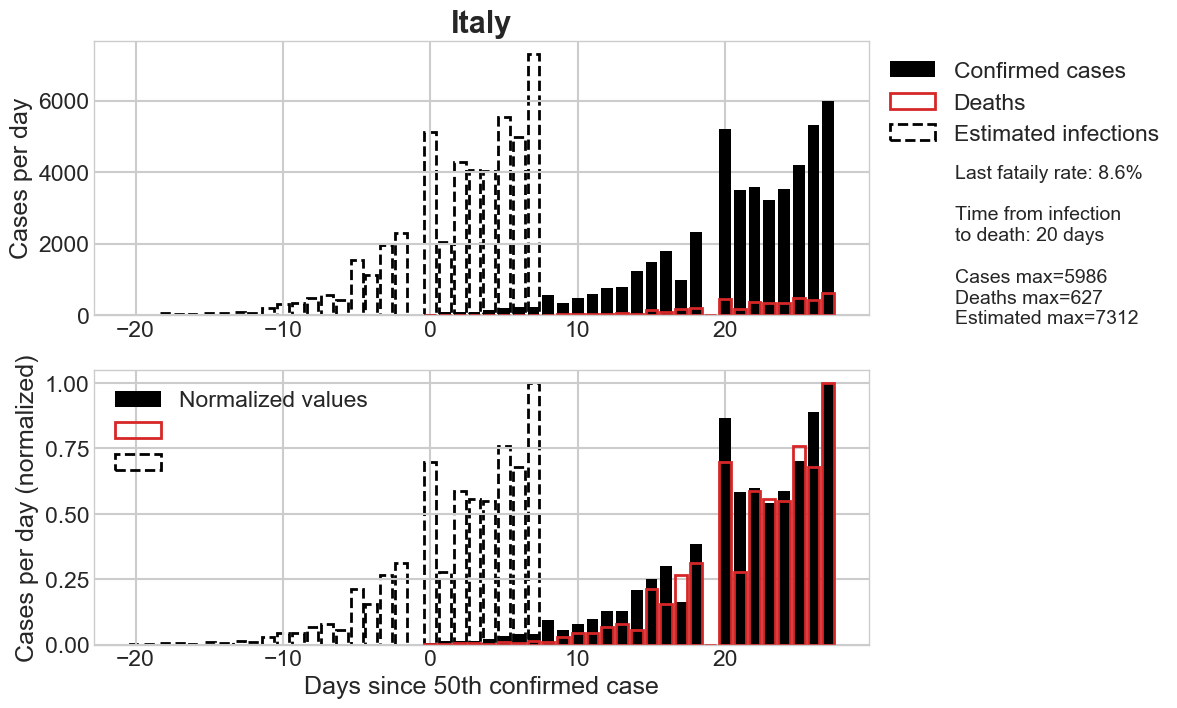

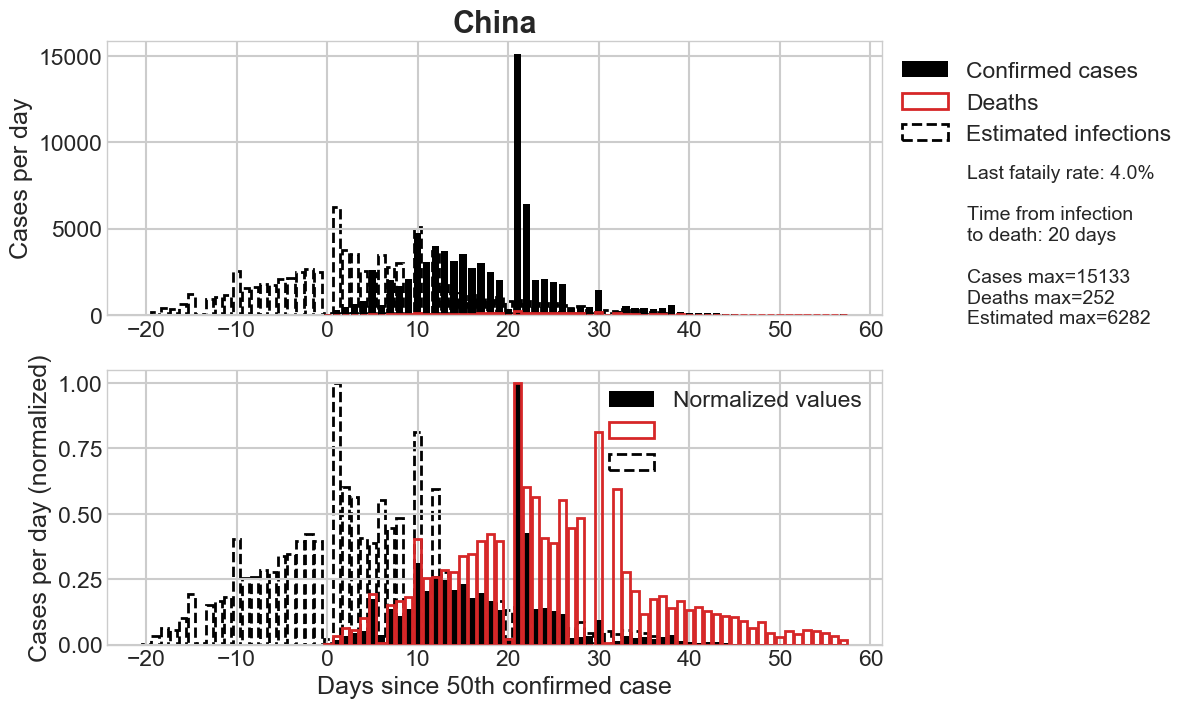

In [12]:
#hide_input
#fig, axs = plt.subplots(1, 1, figsize=(8, 4), dpi=100)
DAYS_INFECTION_TO_DEATH = 20
#FATALITY_RATE = 0.01

ignore = [] #["China", "Switzerland"]
for str_country in get_countries_with_min_cases(df_cases, 'deaths', MIN_DEATHS)[:2]:
    if not str_country in ignore:
        df_cases_country = dff2[dff2['country']==str_country]
        FATALITY_RATE = df_cases_country['fatality'][-1]
        ydata = df_cases_country.confirmed.values
        xdata = np.arange(0, len(ydata))     
        fig, axs = plt.subplots(2, 1, figsize=(10, 8), dpi=100)
        axs[0].set_title(f"{str_country}", fontsize=22, fontweight="bold")
  

        #axs[0].bar(xdata, df_cases_country.new_confirmed, lw=4, label=f"\nConfirmed cases\n(max={int(df_cases_country.new_confirmed.max())})", color='k')
        #axs[0].bar(xdata, df_cases_country.new_deaths, lw=2, label=f"\nDeaths\n(max={int(df_cases_country.new_deaths.max())})", fill=False, edgecolor="C3")

        axs[0].bar(xdata, df_cases_country.new_confirmed, lw=4, label=f"Confirmed cases", color='k')
        axs[0].bar(xdata, df_cases_country.new_deaths, lw=2, label=f"Deaths", fill=False, edgecolor="C3")
               
        axs[0].bar(xdata-DAYS_INFECTION_TO_DEATH, df_cases_country.new_deaths/FATALITY_RATE,
                color='C3',
                lw=2, ls='--', zorder=-10,
                #label=f"\n\nEstimated infections\nTime from infection\nto death: {DAYS_INFECTION_TO_DEATH} days\n(estimated max={int(df_cases_country.new_deaths.max()/FATALITY_RATE)})",                    
                label=f"Estimated infections",                    
                fill=False, edgecolor="k")   
        
        axs[1].bar(xdata, df_cases_country.new_confirmed/df_cases_country.new_confirmed.max(), lw=4, label=f"Normalized values", color='k')
        axs[1].bar(xdata, df_cases_country.new_deaths/df_cases_country.new_deaths.max(), lw=2, label=" ", fill=False, edgecolor="C3")
        axs[1].bar(xdata-DAYS_INFECTION_TO_DEATH, df_cases_country.new_deaths/df_cases_country.new_deaths.max(),
                color='C3',
                lw=2, ls='--', zorder=-10,
                label=" ",
                fill=False, edgecolor="k")        
        
        axs[0].legend(bbox_to_anchor=(1.4, 1.0))
        axs[1].legend()

        plt.xlabel(f"Days since {SINCE_CASES}th confirmed case")
        axs[0].set_ylabel(f"Cases per day")
        axs[1].set_ylabel(f"Cases per day (normalized)")
        
        #coverage = df_cases_country.new_confirmed[-1] / (df_cases_country.new_deaths[-1]/FATALITY_RATE)
        props = dict(boxstyle='round, rounding_size=0.5', pad=0.7, facecolor='white', alpha=0.8)
        plt.text(1.11, 1.75, f"Last fataily rate: {(FATALITY_RATE*100).round(1)}%\n\nTime from infection\nto death: {DAYS_INFECTION_TO_DEATH} days\n\nCases max={int(df_cases_country.new_confirmed.max())}\nDeaths max={int(df_cases_country.new_deaths.max())}\nEstimated max={int(df_cases_country.new_deaths.max()/FATALITY_RATE)}",  
                 transform=axs[1].transAxes, va='top', ha='left',  fontsize=14)        
        #plt.text(1.06, 0.7, f"Last fataily rate: {(FATALITY_RATE*100).round(1)}%\n\nTest coverage: {(coverage*100).round(1)}%",  
        #         transform=axs[1].transAxes, bbox=props)
        
        plt.show()
        

# Cummulative confirmed cases per deaths

`click` the country label that you want to highlight. `Shift` + `click` to compare different countries.

In [33]:
#hide
def make_since_chart(dff2, highlight_countries=[], baseline_countries=[]):
    
    max_date = dff2['date'].max()
    color_domain = list(dff2['country'].unique())
    color_range = list(map(get_country_colors, color_domain))


    selection = alt.selection_multi(fields=['country'], bind='legend', 
                                    init=[{'country': x} for x in highlight_countries + baseline_countries])
    
    COL_X = f'Days since case {SINCE_CASES}'
    dff2['ratio_in'] = 1 / dff2['ratio'] * 100
    
    base = alt.Chart(dff2, width=550).encode(
        x=f'{COL_X}:Q',
        y=alt.Y('ratio_in:Q', axis=alt.Axis(title='Fatality rate (%)')),
        color=alt.Color('country:N', scale=alt.Scale(domain=color_domain, range=color_range)),
        tooltip=list(dff2),
        opacity=alt.condition(selection, alt.value(1), alt.value(0.2))
    )    
    
    # 33% growth reference -----------
    #print(dff2)
    max_day = dff2[COL_X].max()
    ref = pd.DataFrame([[x, SINCE_CASES*1.33**x] for x in range(max_day+1)], columns=[COL_X, 'Confirmed Cases'])
    base_ref = alt.Chart(ref).encode(x=f'{COL_X}:Q', y='Confirmed Cases:Q')
    
    return (
        base.mark_line(point=True).add_selection(selection) + 
        base.transform_filter(
            alt.datum['date'] >= int(max_date.timestamp() * 1000)
        ).mark_text(dy=-8, align='right', fontWeight='bold').encode(text='country:N') #+  
    ).properties(
        title=f"Fatality rates per country"
    )

In [34]:
#hide
chart = make_since_chart(dff2[dff2.country != "China"], ["Germany"],  ['Norway', 'Italy', 'South Korea', 'US'])
chart

/Users/caglar/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


alt.LayerChart(...)

Text(0, 0.5, 'Cummulative cases per deaths')

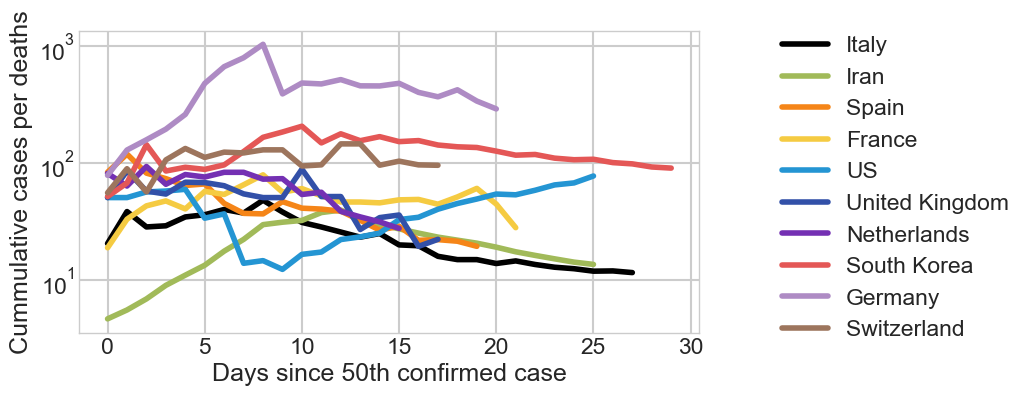

In [15]:
#hide
fig, axs = plt.subplots(1, 1, figsize=(8, 4), dpi=100)
ignore = ["China"]
for str_country in get_countries_with_min_cases(df_cases, 'deaths', MIN_DEATHS):
    if not str_country in ignore and str_country in dff2.country.values:
        #print(str_country)
        df_cases_country = dff2[dff2['country']==str_country]
        ydata = df_cases_country.ratio.values
        #xdata = range(len(ydata))
        xdata = np.arange(0, len(ydata))        
        plt.semilogy(xdata, df_cases_country.ratio, lw=4, label=str_country, c=get_country_colors(str_country))


axs.legend(bbox_to_anchor=(1.1, 1.05))
plt.xlabel(f"Days since {SINCE_CASES}th confirmed case")
plt.ylabel(f"Cummulative cases per deaths")   

# Growth of confirmed cases compared to deaths

Some countries start testnig the population earlier in the outbreak than others. The time delay between the increasing number of deaths and the confirmed number of cases is indicative for speed of the response. 

Here, we measure the distance of the maximum of cumulative deaths and new deaths to the number of infections to estimate the progression of the infection across countries. 

A comparison of countries with respect to their mean time for reponse is presented below.

In [16]:
#hide

from scipy.optimize import curve_fit

def logistic(x, L, k, x0, c):
    #Logistic function
    return (L / (1 + np.exp(-k *(x - x0)))) + c

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


def predict_country(dff2, str_country, by = 'cases', fit_function=logistic):
    # str_country = "Germany"
    df_cases_country = dff2[dff2['country']==str_country]
    ydata = df_cases_country[by].values
    #xdata = range(len(ydata))
    xdata = np.arange(0, len(ydata))
    try:
        popt, pcov = curve_fit(fit_function, xdata, ydata, bounds=(0, [1e6, 0.3, 5e1, 1e10]), )

        PREDICT_DAYS = 7
        xdata_predicted = range(xdata[-1],xdata[-1]+PREDICT_DAYS)
        y_predicted = logistic(xdata_predicted, *popt)

        return xdata_predicted, y_predicted
    except:
        return None, None

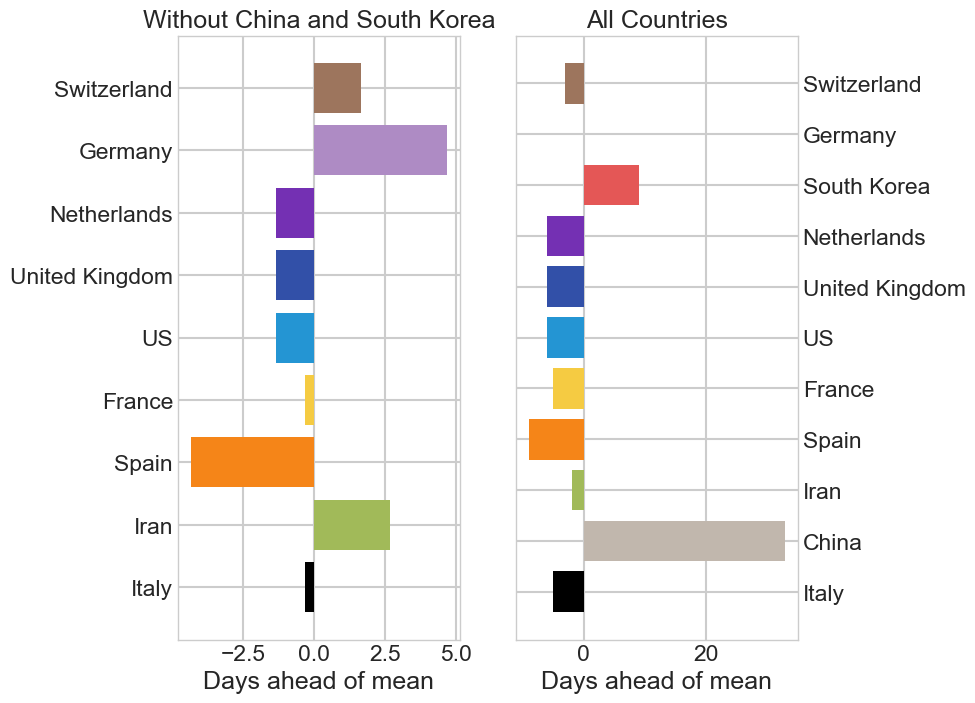

In [17]:
#hide_input
fig, axs = plt.subplots(1, 2, figsize=(8, 8), dpi=100)

ignores = [["China", "South Korea"], []]
for i, ignore in enumerate(ignores):
    countries = get_countries_with_min_cases(df_cases, 'deaths', MIN_DEATHS)
    countries = [c for c in countries if c not in ignore]
    color_domain = countries
    color_range = list(map(get_country_colors, color_domain))
    distances = []
    distances_new = []
    for str_country in countries:
        if not str_country in ignore:
            df_cases_country = dff2[dff2['country']==str_country]
            nearest_idx = find_nearest(df_cases_country.confirmed, df_cases_country.deaths.max())
            distance = df_cases_country.deaths.argmax() -  nearest_idx
            distances.append(distance)

            nearest_idx = find_nearest(df_cases_country.confirmed, df_cases_country.deaths[df_cases_country.new_deaths.argmax()])
            distance = df_cases_country.new_deaths.argmax() -  nearest_idx
            distances_new.append(distance)

    axs[i].barh(countries, np.subtract(distances, np.mean(distances)) , color=color_range)
    axs[i].set_xlabel("Days ahead of mean")

axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()
axs[0].set_title("Without China and South Korea")
axs[1].set_title("All Countries")
plt.show()

To determine the above values, we plot the number of confirmed cases (solid black lines) and the number of deaths (dashed black lines). From this, we measure the distance of the day of maximum deaths (dashed red lines) to the day of confirmed cases at this y-value.

The distance is indicative for how fast the humber of confirmed cases increases comapred to the increase of the number of deaths.

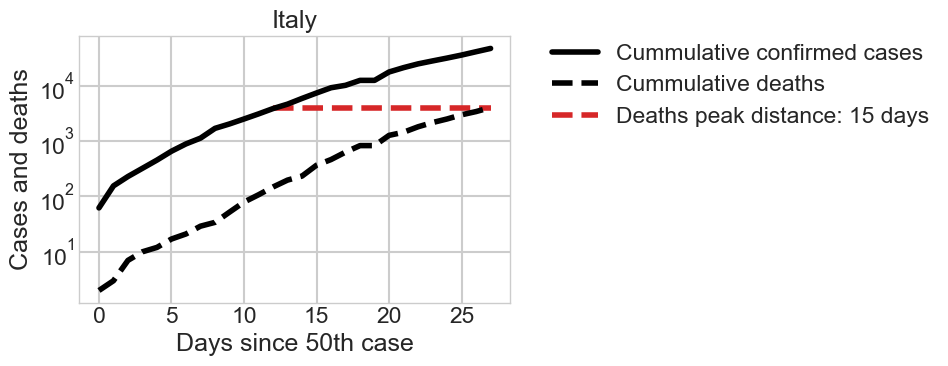

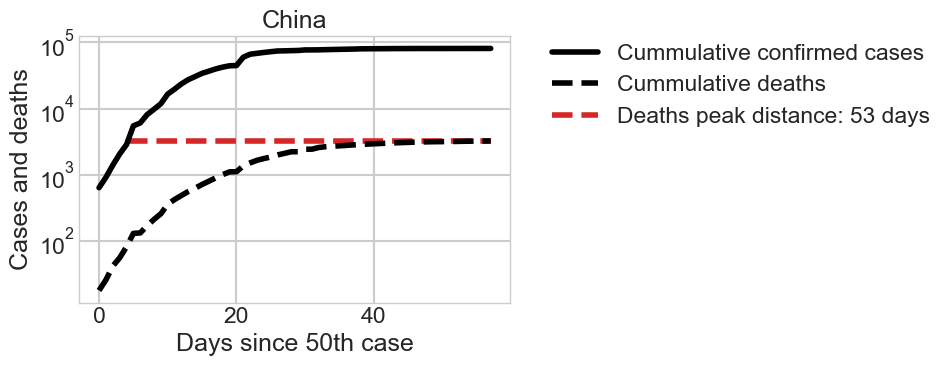

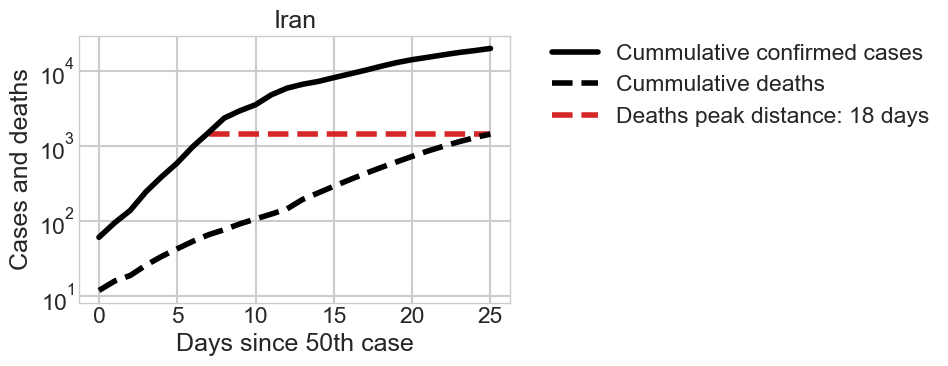

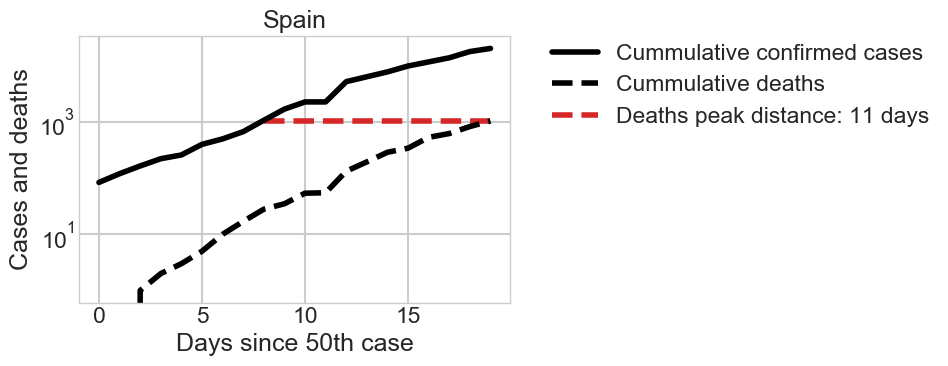

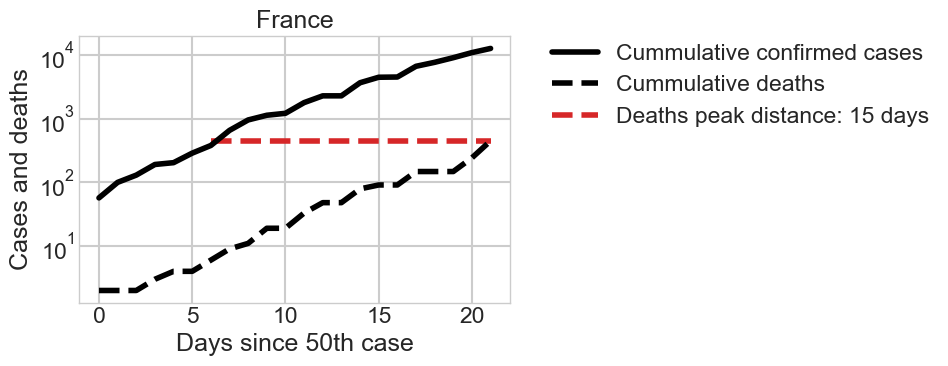

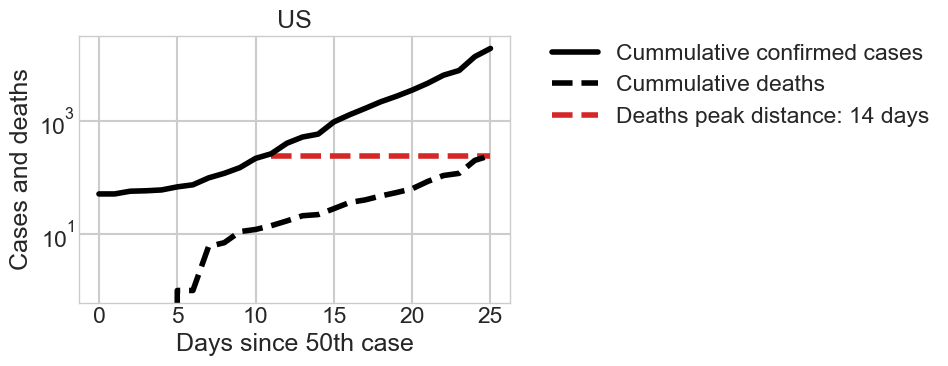

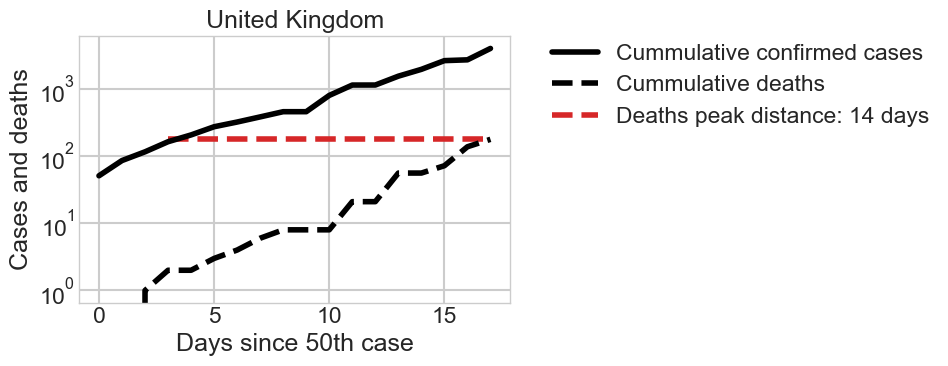

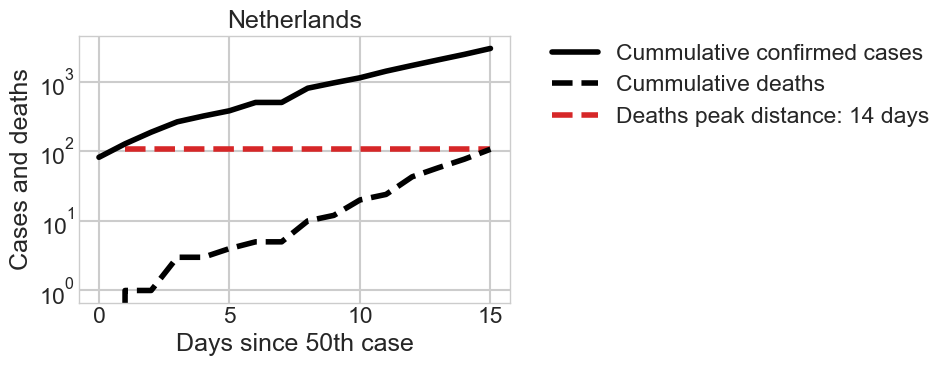

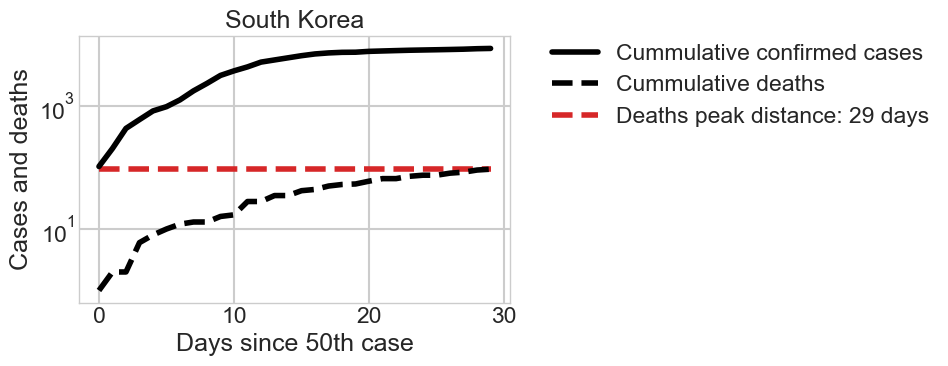

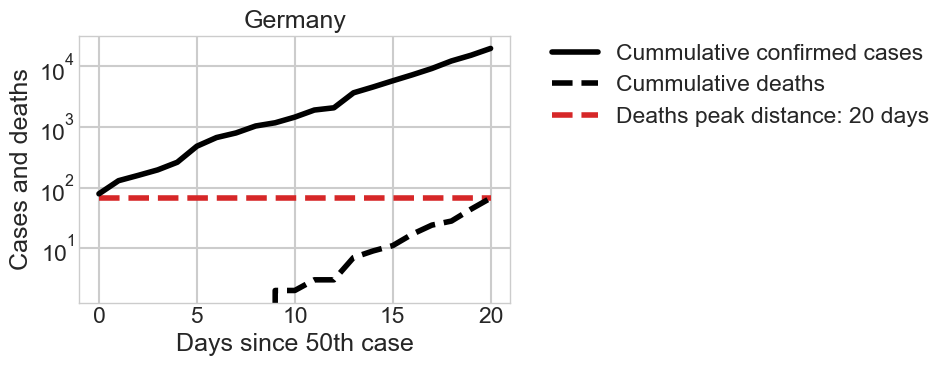

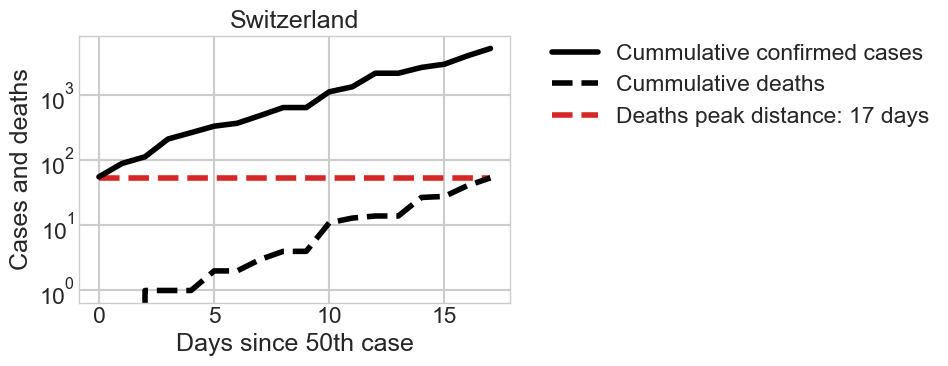

In [21]:
#hide_input
#fig, axs = plt.subplots(1, 1, figsize=(8, 4), dpi=100)
ignore = [] # ["China"]
for str_country in get_countries_with_min_cases(df_cases, 'deaths', MIN_DEATHS):
    if not str_country in ignore:
        #print(str_country)
        df_cases_country = dff2[dff2['country']==str_country]
        
        
        ydata = df_cases_country.confirmed.values
        xdata = np.arange(0, len(ydata))     
        fig, axs = plt.subplots(1, 1, figsize=(10, 4), dpi=100)
        plt.title(str_country)
        
        # first panel
        
        axs.semilogy(xdata, df_cases_country.confirmed, lw=4, ls='-', label="Cummulative confirmed cases", c='k')#c=get_country_colors(str_country))
        axs.semilogy(xdata, df_cases_country.deaths, ls='--', lw=4, label="Cummulative deaths", c='k')# c=get_country_colors(str_country))
        axs.set_ylabel("Cases and deaths")   
        
#         # new deaths
#         axs.bar(xdata, df_cases_country.new_deaths/df_cases_country.new_deaths.max(), lw=2, label="New deaths", fill=False, edgecolor="C3")
#         axs.scatter(df_cases_country.new_deaths.argmax(), df_cases_country.new_deaths.max()/df_cases_country.new_deaths.max(), c="C3", 
#                    label='Maximum new deaths')
        # distance calculation
        
        # distance of deaths peak
        nearest_idx = find_nearest(df_cases_country.confirmed, df_cases_country.deaths.max())
        distance = df_cases_country.deaths.argmax() -  nearest_idx
        axs.hlines(df_cases_country.deaths[df_cases_country.deaths.argmax()], nearest_idx, df_cases_country.deaths.argmax()
                      , color='C3', ls='--', lw=4, label=f"Deaths peak distance: {distance} days"
                     )        
        
#         # distance of new deaths peak
#         nearest_idx = find_nearest(df_cases_country.confirmed, df_cases_country.deaths[df_cases_country.new_deaths.argmax()])
#         distance = df_cases_country.new_deaths.argmax() -  nearest_idx
#         axs.hlines(df_cases_country.deaths[df_cases_country.new_deaths.argmax()], nearest_idx, df_cases_country.new_deaths.argmax()
#                       , color='C3', ls='--', lw=4, label=f"New deaths peak distance: {distance} days"
#                      )        
        
        axs.legend(bbox_to_anchor=(1.05, 1.05))
        axs.set_xlabel(f"Days since {SINCE_CASES}th case")
#         axs[1].set_xlabel(f"Days since {SINCE_CASES}th case")
        fig.tight_layout()
        plt.show()

In [19]:
#hide 
dff2

,country,state,type,confirmed,deaths,ratio,new_deaths,new_confirmed,date,Days since case 50,fatality
date,,,,,,,,,,,
2020-03-04,Malaysia,NaN,confirmed,50,0,50.000000,0.0,14.0,2020-03-04,0,0.000000
2020-03-05,Malaysia,NaN,confirmed,50,0,50.000000,0.0,0.0,2020-03-05,1,0.000000
2020-03-06,Malaysia,NaN,confirmed,83,0,83.000000,0.0,33.0,2020-03-06,2,0.000000
2020-03-07,Malaysia,NaN,confirmed,93,0,93.000000,0.0,10.0,2020-03-07,3,0.000000
2020-03-08,Malaysia,NaN,confirmed,99,0,99.000000,0.0,6.0,2020-03-08,4,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2020-03-16,United Kingdom,NaN,confirmed,1551,56,27.210526,35.0,406.0,2020-03-16,13,0.036106
2020-03-17,United Kingdom,NaN,confirmed,1960,56,34.385965,0.0,409.0,2020-03-17,14,0.028571
2020-03-18,United Kingdom,NaN,confirmed,2642,72,36.191781,16.0,682.0,2020-03-18,15,0.027252
